## 🌳 Multi-Class, Multi-Label Emotion Classification using GoEmotions Reddit Comments Dataset

In this notebook, we explore developing a multi-output random forest emotion classifier using Google's GoEmotions reddit comment data <https://github.com/google-research/google-research/tree/fd2ebbe1cdbd39f3486c0d9812b37214673c3c9d/goemotions/data>

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download(['punkt', 'wordnet', 'stopwords'])
nltk.download('averaged_perceptron_tagger')

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### 1. Import data and conduct reshaping
GoEmotions train/dev/test datasets <https://github.com/google-research/google-research/tree/fd2ebbe1cdbd39f3486c0d9812b37214673c3c9d/goemotions/data>

In [205]:
file_paths = ['https://github.com/google-research/google-research/raw/fd2ebbe1cdbd39f3486c0d9812b37214673c3c9d/goemotions/data/train.tsv',
              'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv',
              'https://github.com/google-research/google-research/raw/master/goemotions/data/test.tsv']

for f in file_paths:
    name = f.rsplit('/', 1)[-1].split('.')[0]
    df_name = name + '_df'
    globals()[df_name] = pd.read_csv(f, sep='\t', header = None, names = ['text','emotion_id','comment_id'])

In [206]:
mapping_file = 'https://github.com/google-research/google-research/raw/master/goemotions/data/emotions.txt'
emotions = pd.read_csv(mapping_file, sep=' ', header = None, names = ['emotion'])
emotions = emotions.to_dict()['emotion']
emotions = {str(k):str(v) for k,v in emotions.items()}

In [207]:
## convert dataframes into wide dataframes
train_df['emotion_id'] = train_df['emotion_id'].str.split(',')
dev_df['emotion_id'] = dev_df['emotion_id'].str.split(',')
test_df['emotion_id'] = test_df['emotion_id'].str.split(',')

train_data = train_df.explode('emotion_id')
dev_data = dev_df.explode('emotion_id')
test_data = test_df.explode('emotion_id')

In [208]:
# ordered list of column names with emotion_id
cols = list(map(str, list(range(28))))

train_data = pd.concat([train_data[['text', 'comment_id']], pd.get_dummies(train_data['emotion_id'])], axis = 1).groupby(['text', 'comment_id']).sum()
train_data = train_data[cols]
train_data = train_data.rename(columns = emotions)

dev_data = pd.concat([dev_data[['text', 'comment_id']], pd.get_dummies(dev_data['emotion_id'])], axis = 1).groupby(['text', 'comment_id']).sum()
dev_data = dev_data[cols].rename(columns = emotions)
dev_data = dev_data.rename(columns = emotions)

test_data = pd.concat([test_data[['text', 'comment_id']], pd.get_dummies(test_data['emotion_id'])], axis = 1).groupby(['text', 'comment_id']).sum()
test_data = test_data[cols].rename(columns = emotions)
test_data = test_data.rename(columns = emotions)

#### 2. Text processing and tokenization
Conduct text processing, tokenization and handle emojis, as emojis are used commonly in Reddit comments and their information should be preserved.

We preserve emojis by converting them into word formats and include them in later modeling stage. Refer to this repo <https://github.com/NeelShah18/emot>

In [209]:
pd.set_option('display.max_columns', None)

In [210]:
train_data.reset_index(inplace=True)
dev_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

In [212]:
## text processing util functions
# stopwords
def remove_stopwords(lines, sw = stopwords.words('english')):
    '''
    The purpose of this function is to remove stopwords from a given array of 
    lines.
    
    params:
        lines (Array / List): The list of lines you want to remove the stopwords from
        sw: The set of stopwords you want to remove
    ''' 
    res = []
    for line in lines:
        original = line
        line = [w for w in line if w not in sw]
        line = [w for w in line if w.isalpha()]
        if len(line) < 1:
            line = original
        res.append(line)
    return res

# emojis/emoticons
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
    return text

# urls/html tags
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# lemmatization
lemmatizer = WordNetLemmatizer()
def finding_lemma(text):
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text)
    return([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


#### packing them into one function for text processing ####
def text_processing(text, sw = stopwords.words('english')):
    '''
    The purpose of this function is to conduct text pre-processing, cleaning and tokenization given dataframe column
    containing input text.
    
    params:
        text: The text column containing text for processing, i.e. emotion_df['summary']
        sw: The set of stopwords you want to remove during text processing

    '''
    lines = list(text)
    
    # remove new lines
    lines = [line.rstrip('\n') for line in lines]
    # remove punctuations from each line
    lines = [line.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for line in lines]
    lines = [' '.join(line.split()) for line in lines]
    # lemmatization
    lines = [finding_lemma(line.split()) for line in lines]
    lines = [' '.join(line) for line in lines]
    # convert emojis/emoticons
    lines = [convert_emojis(line) for line in lines]
    lines = [convert_emoticons(line) for line in lines]
    # make all characters lower
    lines = [line.lower() for line in lines]
    # remove urls/html tags
    lines = [remove_urls(line) for line in lines]
    lines = [remove_html(line) for line in lines]
    # tokenize
    lines = [word_tokenize(line) for line in lines]
    # remove stopwords
    cleaned_lines = remove_stopwords(lines = lines, sw = stopwords.words('english'))   
    
    return cleaned_lines

In [213]:
# process and tokenize texts
train_data['text_tokens'] = text_processing(train_data['text'])
train_data['text_tokens'] = train_data['text_tokens'].map(' '.join)
dev_data['text_tokens'] = text_processing(dev_data['text'])
dev_data['text_tokens'] = dev_data['text_tokens'].map(' '.join)
test_data['text_tokens'] = text_processing(test_data['text'])
test_data['text_tokens'] = test_data['text_tokens'].map(' '.join)

#### 3. Create training pipelines for Random Forest and XGBoost estimators
In this step we create two pipelines using Random Forest estimator and XBGoost estimator.

In [251]:
## review shape of train/dev/test datasets
X_train = train_data['text_tokens']
Y_train = train_data.iloc[:, 2:-1].to_numpy()
X_dev = dev_data['text_tokens']
Y_dev = dev_data.iloc[:, 2:-1].to_numpy()
X_test = test_data['text_tokens']
Y_test = test_data.iloc[:, 2:-1].to_numpy()

print(f"the shape of the training set (input) is: {X_train.shape}")
print(f"the shape of the training set (target) is: {Y_train.shape}\n")
print(f"the shape of the validation set (input) is: {X_dev.shape}")
print(f"the shape of the validation set (target) is: {Y_dev.shape}\n")
print(f"the shape of the test set (input) is: {X_test.shape}")
print(f"the shape of the test set (target) is: {Y_test.shape}\n")

the shape of the training set (input) is: (43410,)
the shape of the training set (target) is: (43410, 28)

the shape of the validation set (input) is: (5426,)
the shape of the validation set (target) is: (5426, 28)

the shape of the test set (input) is: (5427,)
the shape of the test set (target) is: (5427, 28)



In [254]:
## set up pipelines containing text token processing and modeling
rf_estimator = RandomForestClassifier(max_depth = 10,
                                     n_estimators = 200,
                                     random_state=0)
rf_pipeline = Pipeline([
        ('transformer', Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer())])),
        ('classifier', MultiOutputClassifier(rf_estimator))        
        ])


xgb_estimator = xgb.XGBClassifier(n_estimators = 200,
                                 random_state =0,
                                 objective='binary:logistic')
xgb_pipeline = Pipeline([
        ('transformer', Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer())])),
        ('classifier', MultiOutputClassifier(xgb_estimator))        
        ])

In [255]:
print(rf_pipeline)
print(xgb_pipeline)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('vectorizer', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                                        n_estimators=200,
                                                                        random_state=0)))])
Pipeline(steps=[('transformer',
                 Pipeline(steps=[('vectorizer', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
             

#### 4. Build initial RF model and XGB model for evaluation
Let's build two initial models for evaluation without hyperparameter-tuning and conduct initial evaluations.

Other than accuracy, precision, recall and f1-score, we also define α-evaluation score, which is introduced by Boutell et. al. in [Learning multi-label scene classification](https://www.rose-hulman.edu/~boutell/publications/boutell04PRmultilabel.pdf).

In [256]:
## function that implements alpha-evaluation score for multi-label classifications
def alpha_evaluation(y_true, y_pred):
    """
    This function implements alpha-evaluation score for evaluating multi-label classification tasks.
    Score reference - https://www.rose-hulman.edu/~boutell/publications/boutell04PRmultilabel.pdf
    """
    alpha = 1
    beta = 0.25
    gamma = 1
    
    # compute true positives across training examples and labels
    tp = np.sum(np.logical_and(y_true, y_pred))
    
    # compute false negatives (Missed Labels) across training examples and labels
    fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))
    
    # compute False Positive across training examples and labels.
    fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
        
    # Compute alpha evaluation score
    alpha_score = (1 - ((beta * fn + gamma * fp ) / (tp +fn + fp + 0.00001)))**alpha 
    
    return alpha_score

In [257]:
## function that conducts model evaluation by individual emotion label category
def evaluate_model(model, X_dev, Y_dev, emotion_names):
    '''
    This function returns a dataframe with selected evaluation metrics:
    accuracy, precision, recall, f1-score, roc_auc_score and alpha-evaluation score.
    
    params:
        model - trained model
        X_dev - validation input
        Y_dev - validation target
        emotion_names - list of emotion label names from [v for k, v in emotions.items()]
        
    returns:
        A dataframe
    '''
    score_df = {}
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    auc_list = []
    alphascore_list = []
    
    y_pred = model.predict(X_dev)
    
    for i in range(Y_dev.shape[1]):
        ghy = classification_report(Y_dev[:,i], y_pred[:,i], output_dict = True)
        vg =  accuracy_score(Y_dev[:,i], y_pred[:,i])
        alpha = alpha_evaluation(Y_dev[:,i], y_pred[:,i])
        auc = roc_auc_score(Y_dev[:,i], y_pred[:,i])
        accuracy_list.append(vg)
        precision_list.append(ghy['weighted avg']['precision'])
        recall_list.append(ghy['weighted avg']['recall'])
        f1score_list.append(ghy['weighted avg']['f1-score'])
        auc_list.append(auc)
        alphascore_list.append(alpha)
        
        
    score_df = pd.DataFrame({'Variable':emotion_names,
                             'Accuracy':accuracy_list,
                             'Precision':precision_list,
                             'Recall':recall_list,
                             'F1-Score':f1score_list,
                             'ROC-AUC':auc_list,
                             'Alpha-Score':alphascore_list})
    
    score_df.set_index('Variable', inplace = True)
    return score_df

In [258]:
## build and evaluate Random Forest classifier model
rf_pipeline.fit(X_train, Y_train)
evaluate_model(rf_pipeline, X_dev, Y_dev, [v for k, v in emotions.items()])

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Alpha-Score
Variable,,,,,,
admiration,0.910063,0.828214,0.910063,0.867211,0.5,0.75
amusement,0.944158,0.891434,0.944158,0.917039,0.5,0.75
anger,0.964062,0.929415,0.964062,0.946422,0.5,0.75
annoyance,0.944158,0.891434,0.944158,0.917039,0.5,0.75
approval,0.926834,0.859021,0.926834,0.891640,0.5,0.75
caring,0.971802,0.944400,0.971802,0.957905,0.5,0.75
confusion,0.971987,0.944758,0.971987,0.958179,0.5,0.75
curiosity,0.954294,0.910677,0.954294,0.931976,0.5,0.75
desire,0.985809,0.971820,0.985809,0.978764,0.5,0.75


In [259]:
## build and evaluate XGBoost classifier model
xgb_pipeline.fit(X_train, Y_train)
evaluate_model(xgb_pipeline, X_dev, Y_dev, [v for k, v in emotions.items()])

,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Alpha-Score
Variable,,,,,,
admiration,0.941393,0.935855,0.941393,0.936666,0.753587,0.749129
amusement,0.970328,0.969594,0.970328,0.969924,0.846108,0.748667
anger,0.965721,0.956016,0.965721,0.957165,0.589727,0.699324
annoyance,0.942499,0.914654,0.942499,0.920734,0.520858,0.707822
approval,0.929230,0.909601,0.929230,0.903350,0.539573,0.733813
caring,0.970512,0.956044,0.970512,0.960087,0.527895,0.692308
confusion,0.974014,0.968041,0.974014,0.964846,0.558547,0.745283
curiosity,0.957796,0.954584,0.957796,0.941003,0.544065,0.762948
desire,0.988942,0.987200,0.988942,0.986463,0.648790,0.765060


XGBoost classifier does a much better job than Random Forest classifier on validation data, especially in 'neutral' category which is difficult to classify. We can also see that certain emotions are easier to classify correctly than the others, such as embarrassment, grief, pride and relief. This is probably because certain emotions are more uniformly detected by humans than others, usually stronger emotions.

#### 5. Hyperparameter-tuning to improve Random Forest classifier
In reality this step is not needed, as we have demonstrated XGBoost classifier does a better job on this task and XGBoost generally has good default parameters already. We use this section to explore how much we could improve on the Random Forest classifier for this task.

The hyperparameters to focus on for Random Forest classifier are:

- **min_samples_split**: The minimum number of samples required to split an internal node. Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
- **max_depth**: The maximum depth of the tree. Choosing a lower max_depth can reduce the number of splits and may help to reduce overfitting.
- **n_estimators**: The number of Decision Trees that make up the Random Forest.

The evaluation metric to use is the **alpha-evaluation score**.

In [277]:
min_samples_split_list = [30, 50, 100, 200, 300]
max_depth_list = [2, 4, 8, 16, 32, 64, 128, 256]
n_estimators_list = [10, 50, 100, 200, 500, 1000]

In [ ]:
## min_samples_split
alphascore_list_train = []
alphascore_list_val = []

for min_samples_split in min_samples_split_list:
    estimator = RandomForestClassifier(min_samples_split = min_samples_split, random_state =0)
    pipeline = Pipeline([
            ('transformer', Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer())])),
            ('classifier', MultiOutputClassifier(estimator))        
            ])
    model = pipeline.fit(X_train,Y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_dev) ## The predicted values for the dev(validation) dataset
    
    alpha_train = alpha_evaluation(Y_train, predictions_train)
    alpha_val = alpha_evaluation(Y_dev, predictions_val)
    alphascore_list_train.append(alpha_train)
    alphascore_list_val.append(alpha_val)

plt.title('Train x Validation Metrics')
plt.xlabel('min_samples_split')
plt.ylabel('alpha-evaluation score')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(alphascore_list_train)
plt.plot(alphascore_list_val)
plt.legend(['Train','Validation'])

In [ ]:
## max_depth
alphascore_list_train = []
alphascore_list_val = []
for max_depth in max_depth_list:
    estimator = RandomForestClassifier(max_depth = max_depth, random_state =0)
    pipeline = Pipeline([
            ('transformer', Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer())])),
            ('classifier', MultiOutputClassifier(estimator))        
            ])
    model = pipeline.fit(X_train,Y_train) 
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_dev)
    
    alpha_train = alpha_evaluation(Y_train, predictions_train)
    alpha_val = alpha_evaluation(Y_dev, predictions_val)
    alphascore_list_train.append(alpha_train)
    alphascore_list_val.append(alpha_val)

plt.title('Train x Validation Metrics')
plt.xlabel('max_depth')
plt.ylabel('alpha-evaluation score')
plt.xticks(ticks = range(len(max_depth_list)),labels=max_depth_list) 
plt.plot(alphascore_list_train)
plt.plot(alphascore_list_val)
plt.legend(['Train','Validation'])

In [ ]:
## n_estimators
alphascore_list_train = []
alphascore_list_val = []
for n_estimators in n_estimators_list:
    estimator = RandomForestClassifier(n_estimators = n_estimators, random_state =0)
    pipeline = Pipeline([
            ('transformer', Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer())])),
            ('classifier', MultiOutputClassifier(estimator))        
            ])
    model = pipeline.fit(X_train,Y_train) 
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_dev) 
    
    alpha_train = alpha_evaluation(Y_train, predictions_train)
    alpha_val = alpha_evaluation(Y_dev, predictions_val)
    alphascore_list_train.append(alpha_train)
    alphascore_list_val.append(alpha_val)

plt.title('Train x Validation Metrics')
plt.xlabel('n_estimators')
plt.ylabel('alpha-evaluation score')
plt.xticks(ticks = range(len(n_estimators_list)),labels=n_estimators_list) 
plt.plot(alphascore_list_train)
plt.plot(alphascore_list_val)
plt.legend(['Train','Validation'])

In [280]:
## use GridSearchCV() to find the best combination of hyperparameters for Random Forest
parameters = { 
    # 'transformer__vectorizer__max_features': [20000, 10000, 5000, 3000, 1000],
    # 'transformer__vectorizer__ngram_range': ((1,1),(1,2),(1,3)),
    # 'transformer__tfidf__use_idf': (True, False),
    'classifier__estimator__min_samples_split': [100,200],
    'classifier__estimator__max_depth': [4, 8, 16, 32],
    'classifier__estimator__n_estimators': [50, 100, 200, 300]  
            }

estimator = RandomForestClassifier(random_state=0)
pipeline = Pipeline([
        ('transformer', Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer())])),
        ('classifier', MultiOutputClassifier(estimator))        
        ])
model_best = GridSearchCV(pipeline, param_grid = parameters,
                          scoring={'alpha-evaluation score': make_scorer(alpha_evaluation)},
                          refit='alpha-evaluation score',
                          n_jobs = -1, cv = 3, verbose = 1)

model_best.fit(X_train,Y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        Pipeline(steps=[('vectorizer',
                                                         CountVectorizer()),
                                                        ('tfidf',
                                                         TfidfTransformer())])),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(random_state=0)))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__max_depth': [4, 8, 16, 32],
                         'classifier__estimator__min_samples_split': [100, 200],
                         'classifier__estimator__n_estimators': [50, 100, 200,
                                                                 300]},
             refit='alpha-evaluation score',
             scoring={'alpha-evaluation score': make_scorer(alpha_evaluation)},
             verbose=1)

In [281]:
model_best.best_params_

{'classifier__estimator__max_depth': 32,
 'classifier__estimator__min_samples_split': 100,
 'classifier__estimator__n_estimators': 100}

In [282]:
evaluate_model(model_best, X_dev, Y_dev, [v for k, v in emotions.items()])

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Alpha-Score
Variable,,,,,,
admiration,0.910063,0.828214,0.910063,0.867211,0.5,0.75
amusement,0.944158,0.891434,0.944158,0.917039,0.5,0.75
anger,0.964062,0.929415,0.964062,0.946422,0.5,0.75
annoyance,0.944158,0.891434,0.944158,0.917039,0.5,0.75
approval,0.926834,0.859021,0.926834,0.891640,0.5,0.75
caring,0.971802,0.944400,0.971802,0.957905,0.5,0.75
confusion,0.971987,0.944758,0.971987,0.958179,0.5,0.75
curiosity,0.954294,0.910677,0.954294,0.931976,0.5,0.75
desire,0.985809,0.971820,0.985809,0.978764,0.5,0.75


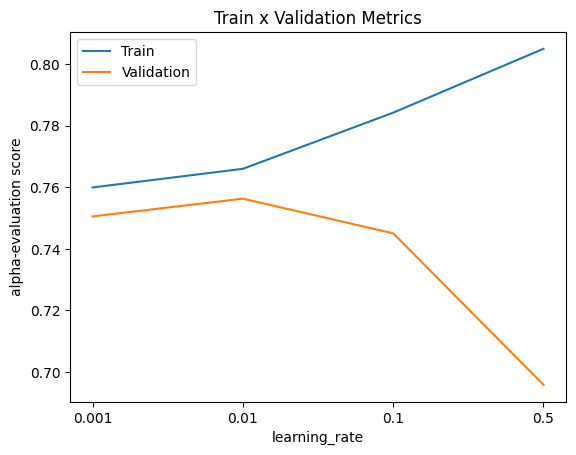

In [285]:
## additionally, tuning learning_rate for XGBoost classifier
alphascore_list_train = []
alphascore_list_val = []

lr_list = [0.001, 0.01, 0.1,0.5]
for lr in lr_list:
    estimator = xgb.XGBClassifier(n_estimators = 200, random_state =0, objective='binary:logistic', learning_rate = lr)
    pipeline = Pipeline([
            ('transformer', Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer())])),
            ('classifier', MultiOutputClassifier(estimator))        
            ])
    model = pipeline.fit(X_train,Y_train) 
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_dev) 
    
    alpha_train = alpha_evaluation(Y_train, predictions_train)
    alpha_val = alpha_evaluation(Y_dev, predictions_val)
    alphascore_list_train.append(alpha_train)
    alphascore_list_val.append(alpha_val)

plt.title('Train x Validation Metrics')
plt.xlabel('learning_rate')
plt.ylabel('alpha-evaluation score')
plt.xticks(ticks = range(len(lr_list)),labels=lr_list) 
plt.plot(alphascore_list_train)
plt.plot(alphascore_list_val)
plt.legend(['Train','Validation'])

In [288]:
## lr = 0.01 and report on model test data metrics 
xgb_estimator_best = xgb.XGBClassifier(n_estimators = 200,
                                       random_state =0,
                                       learning_rate = 0.01,
                                       objective='binary:logistic')
xgb_pipeline_best = Pipeline([
        ('transformer', Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer())])),
        ('classifier', MultiOutputClassifier(xgb_estimator))        
        ])

xgb_pipeline_best.fit(X_train, Y_train)
evaluate_model(xgb_pipeline_best, X_test, Y_test, [v for k, v in emotions.items()])

,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Alpha-Score
Variable,,,,,,
admiration,0.931270,0.923126,0.931270,0.924274,0.714558,0.725376
amusement,0.975861,0.975332,0.975861,0.975572,0.857923,0.761610
anger,0.964621,0.953754,0.964621,0.954969,0.575892,0.700673
annoyance,0.942694,0.925184,0.942694,0.921857,0.540425,0.730030
approval,0.936060,0.914309,0.936060,0.914574,0.544152,0.714474
caring,0.975124,0.965536,0.975124,0.966831,0.546920,0.706081
confusion,0.972913,0.964607,0.972913,0.963206,0.548166,0.731481
curiosity,0.948959,0.942367,0.948959,0.926001,0.515651,0.752622
desire,0.986180,0.982715,0.986180,0.982973,0.613429,0.712766


#### 6. Use XGBoost Classifier to make predictions

In [305]:
predictions = xgb_pipeline_best.predict(X_test)

In [326]:
idx = 132
print(f'Reddit comment: {test_data.iloc[idx,0]}\n')
print(f'Classified emotions in comment: {predictions[idx]}\n')
print(f'True emotions in comment: {Y_test[idx]}')

Reddit comment: > no money at what normal, un-secterian people want! Surely not being sectarian should be considered normal in a civilised democratic society

Classified emotions in comment: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

True emotions in comment: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
